In [1]:
import dataclasses
import math
import matplotlib.pyplot as plt
import numpy as np

from pycpd import RigidRegistration
from typing import Tuple, Iterable

''' Параметры карты и параметры сканирования робота'''

GRID_SIZE = 70
''' Шаг лидара'''

angleIncrementLidar = 3
''' Область сканирования лидара в градусах'''

angleRangeLidar = 360
''' Максимальная дистанция лидара'''

maximumDistanceLidar = 35

'''Выполнили сканирование (предполагаем, что позиция - 0,0).
Отразили его на карте (относительно "0,0").
3.1. Переместились на (x, y).
3.2. Произвели новое сканирование.
3.3. Рассчитали изменение положения (scan[-2], scan[-1]).
3.4. Отразили на карте, начиная с точки (old_x + estimated_x, old_y + estimated_y, old_angle + estimated_angle).
Повторяем шаг 3, пока есть место для продолжения.'''

'Выполнили сканирование (предполагаем, что позиция - 0,0).\nОтразили его на карте (относительно "0,0").\n3.1. Переместились на (x, y).\n3.2. Произвели новое сканирование.\n3.3. Рассчитали изменение положения (scan[-2], scan[-1]).\n3.4. Отразили на карте, начиная с точки (old_x + estimated_x, old_y + estimated_y, old_angle + estimated_angle).\nПовторяем шаг 3, пока есть место для продолжения.'

In [2]:
@dataclasses.dataclass
class Robot_Position:
    x: float
    y: float
    theta: float  # в радианах


@dataclasses.dataclass
class Room:
    map_as_2d_array: np.ndarray
    map_size: int
    obstacle_positions: Iterable[Tuple[float, float]]


@dataclasses.dataclass
class Transformation:
    s: float  # Scale factor
    R: np.array  # Rotation matrix
    t: Tuple[float, float]  # Translation vector


@dataclasses.dataclass
class RoomTestSetup:
    blockpositions: Iterable[Tuple[float, float]]
    androidpositions: Iterable[Robot_Position]

In [3]:
def filledArea(x0: int, y0: int, x1: int, y1: int):
    obstacles = []
    for i in range(x1 - x0):
        for j in range(y1 - y0):
            obstacles.append((x0 + i, y0 + j))
    return obstacles


def filledLinearPath(x0: int, y0: int, x1: int, y1: int):
    obstacles = []
    if y0 == y1:
        for i in range(x1 - x0):
            obstacles.append((x0 + i, y0))
    elif x0 == x1:
        for j in range(y1 - y0):
            obstacles.append((x0, y0 + j))
    else:
        raise Exception("линия должна быть прямой")
    return obstacles


''' Расположение объектов на карте и робота'''

blockpositions1 = [
    *filledArea(1, 1, 15, GRID_SIZE - 1),
    *filledArea(35, 1, GRID_SIZE - 1, 15),
    *filledArea(35, 35, GRID_SIZE - 1, GRID_SIZE - 1),
]

blockpositions1 = list(set(blockpositions1))

structurepositions_room = [
    *filledArea(1, 1, 10, 40),
    *filledArea(1, 40, 30, GRID_SIZE - 1),
    *filledArea(40, 1, GRID_SIZE - 1, 25),
    *filledArea(55, 25, GRID_SIZE - 1, GRID_SIZE - 1),
]

''' T- образная комната'''
test_configuration1 = RoomTestSetup(
    blockpositions=blockpositions1,
    androidpositions=[
        Robot_Position(x=30, y=5, theta=math.radians(0)),
        Robot_Position(x=30, y=8, theta=math.radians(0)),
        Robot_Position(x=30, y=10, theta=math.radians(0)),
        Robot_Position(x=30, y=15, theta=math.radians(0)),
        Robot_Position(x=30, y=20, theta=math.radians(0)),
        Robot_Position(x=30, y=25, theta=math.radians(0)),
        Robot_Position(x=30, y=30, theta=math.radians(0)),
        Robot_Position(x=30, y=35, theta=math.radians(0)),
        Robot_Position(x=30, y=40, theta=math.radians(0)),
        Robot_Position(x=30, y=45, theta=math.radians(0)),
        Robot_Position(x=30, y=50, theta=math.radians(0)),
        Robot_Position(x=30, y=45, theta=math.radians(0)),
        Robot_Position(x=30, y=40, theta=math.radians(0)),
        Robot_Position(x=30, y=35, theta=math.radians(0)),
        Robot_Position(x=30, y=30, theta=math.radians(0)),
        Robot_Position(x=35, y=25, theta=math.radians(0)),
        Robot_Position(x=40, y=25, theta=math.radians(0)),
        Robot_Position(x=45, y=25, theta=math.radians(0)),
        Robot_Position(x=50, y=25, theta=math.radians(0)),
        Robot_Position(x=55, y=25, theta=math.radians(0)),
    ]
)

'''Создание комнаты с роботом'''

def createRoom(
        roomSize: int,
        obstaclePose: Iterable[Tuple[int, int]],
        robotPose: Robot_Position,
) -> Room:
    room = np.zeros((roomSize, roomSize))
    for obstacle_position in obstaclePose:
        room[obstacle_position[::-1]] = 1

    for i in range(roomSize):
        room[(0, i)] = 1
        room[(i, 0)] = 1
        room[(i, roomSize - 1)] = 1
        room[(roomSize - 1, i)] = 1

    room[(robotPose.x, robotPose.y)[::-1]] = 0.65  # 0.5 определяет робота

    return Room(map_as_2d_array=room, map_size=roomSize, obstacle_positions=obstaclePose)


def laserDistancesScan(pos: Robot_Position, room, step=angleIncrementLidar, max_distance=maximumDistanceLidar) -> (
        np.ndarray, np.ndarray):
    """
    Функция осуществляет лазерное сканирование (aka LIDAR)
    Возвращает отсканированные расстояния (-1 - дальше чем макс. дистанция) и углы
    """
    angleStart = math.degrees(pos.theta)
    angleStart = round(
        angleStart)
    angles = np.arange(angleStart, angleStart + angleRangeLidar, step) % 360
    distanceMeasurements = []

    for angle in angles:
        rad = np.radians(angle)
        distance = -1  # По умолчанию -1 если препятствие не обнаружено
        for r in range(1, max_distance):
            x = round(pos.x + r * np.cos(rad))
            y = round(pos.y + r * np.sin(rad))

            # Проверяем стены и препятствия
            if x < 0 or y < 0 or x >= GRID_SIZE or y >= GRID_SIZE or room[y, x] == 1:
                distance = r
                break

        distanceMeasurements.append(distance)
    return np.array(distanceMeasurements), angles


"""Визуализирует карту, робота, препятствия и результаты сканирования"""


def displayScanResults(pose: Robot_Position, scan_distances, angles, room, obstacle_positions) -> None:
    plt.figure(figsize=(6, 6))
    plt.imshow(room, cmap='Greys', origin='lower')
    plt.scatter(*zip(*obstacle_positions), color='black', label='Преграды')
    plt.scatter(pose.x, pose.y, color='orange', label='Android', s=100)

    angles = np.radians(angles)

    # Рисуем линии на каждый выпущенный луч скана
    for i, (angle, distance) in enumerate(zip(angles, scan_distances)):
        if distance != -1:  # Проверяем было ли препятствие
            end_point = (pose.x + distance * np.cos(angle), pose.y + distance * np.sin(angle))
            color = 'orange' if i == 0 else 'green'  # Первый луч - угол робота - другим цветом
            linewidth = 2.0 if i == 0 else 0.5
            plt.plot([pose.x, end_point[0]], [pose.y, end_point[1]], color=color, linewidth=linewidth)

    plt.xlabel('X axis ')
    plt.ylabel('Y axis')
    plt.title('Карта с позиционированием робота и результатами сканирования')
    plt.legend()
    plt.grid(True)
    plt.show()


def generatePointCloudFromScan(scan_distances, angles):
    anglesRadians = np.radians(np.arange(0, angleRangeLidar, angleIncrementLidar))
    acceptableMeasurements = scan_distances[scan_distances > 0]
    valid_angles_rad = anglesRadians[scan_distances > 0]

    x_coordinate_axis = acceptableMeasurements * np.cos(valid_angles_rad)
    y_coordinate_axis = acceptableMeasurements * np.sin(valid_angles_rad)

    return np.column_stack((x_coordinate_axis, y_coordinate_axis))


def displayPointClouds(A, B, transformed_A=None):
    plt.figure(figsize=(6, 6))
    plt.scatter(A[:, 0], A[:, 1], color='red', marker='^', label='Массив точек 1')
    plt.scatter(B[:, 0], B[:, 1], color='blue', marker='o', label='Массив точек 2')

    if transformed_A is not None:
        plt.scatter(transformed_A[:, 0], transformed_A[:, 1], color='green', marker='x',
                    label='Трансформированое облако точек 1')

    plt.title("Визуализация облаков точек")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

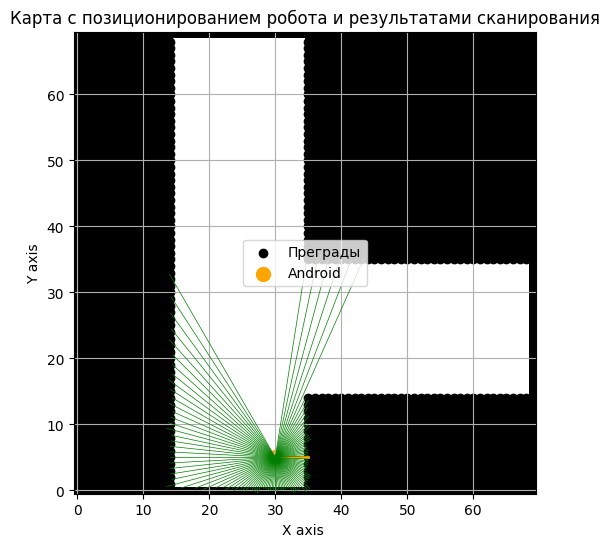

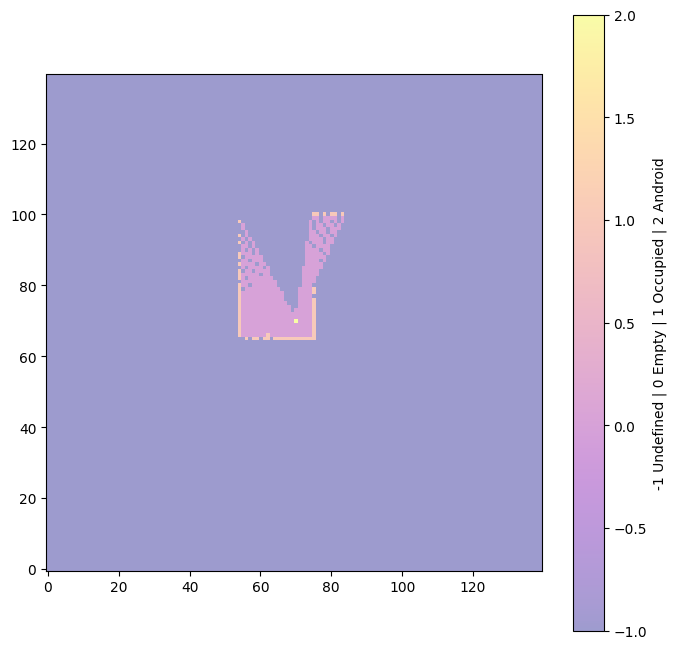

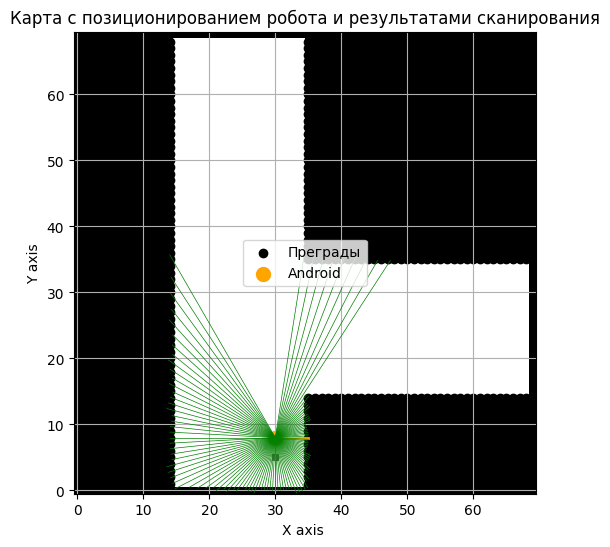

accumulated_actual_x_difference=0.0, actual_diff_y_accum=3.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=0.10269912538943116, estimated_diff_y_accum=3.005010966110693, estimated_diff_theta_accum=0.03162409436562762
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=566
i=1 Grid and Map area diff: 72.24%


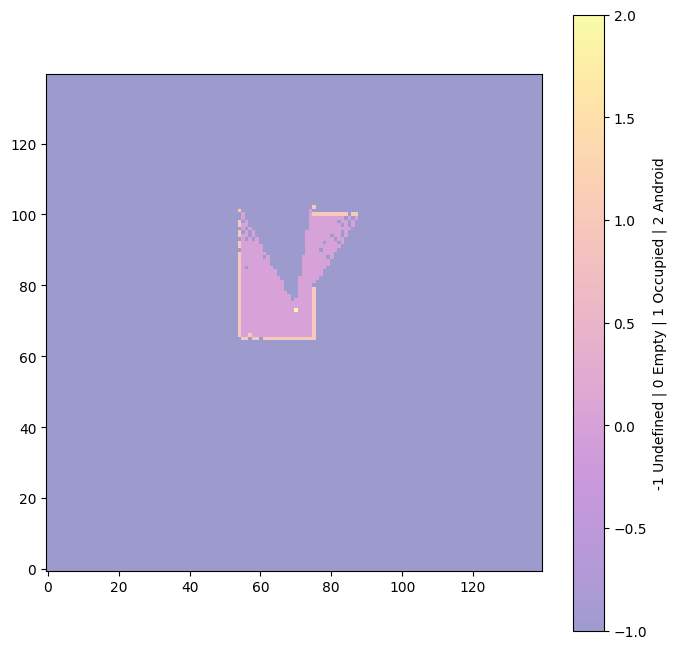

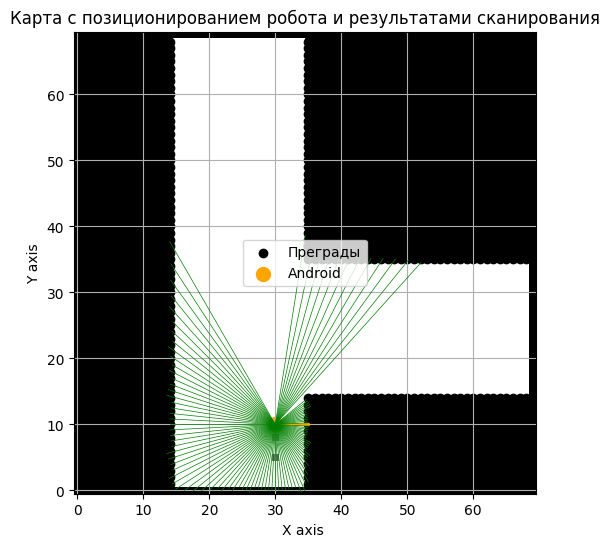

accumulated_actual_x_difference=0.0, actual_diff_y_accum=5.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=0.11457662195512519, estimated_diff_y_accum=4.897899210509914, estimated_diff_theta_accum=0.06293032447710303
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=664
i=2 Grid and Map area diff: 67.44%


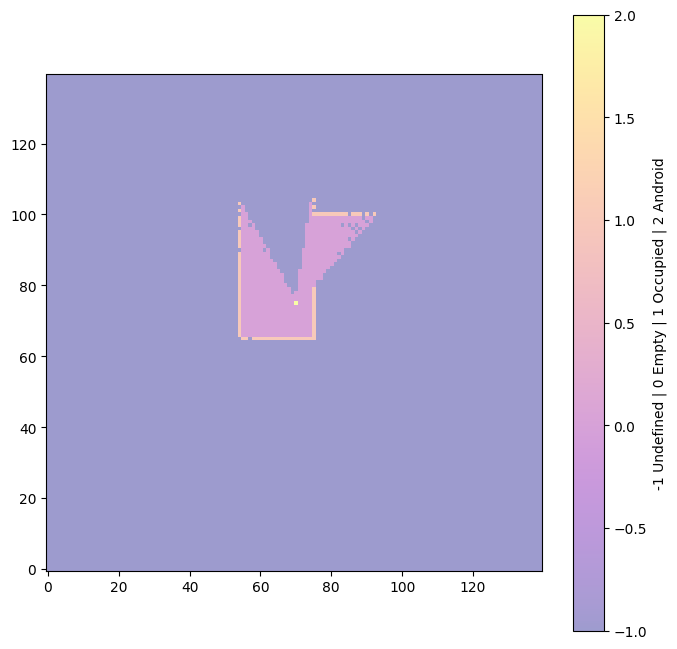

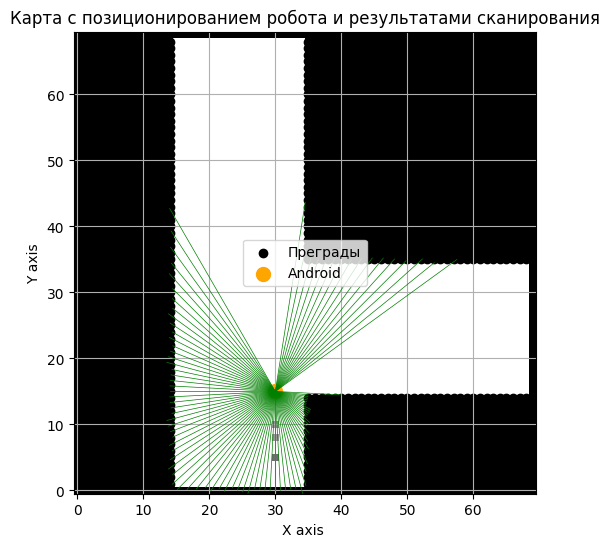

accumulated_actual_x_difference=0.0, actual_diff_y_accum=10.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-0.006804466954558386, estimated_diff_y_accum=9.590458100645586, estimated_diff_theta_accum=0.09548940380329346
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=791
i=3 Grid and Map area diff: 61.21%


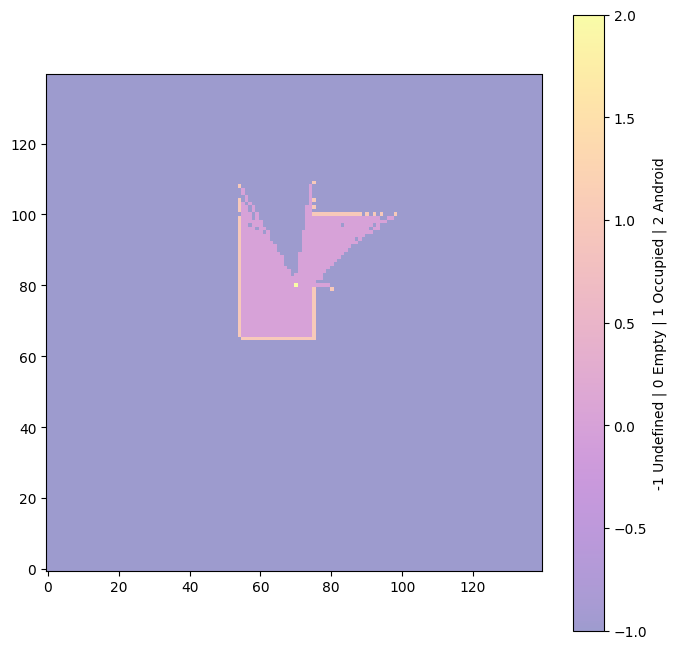

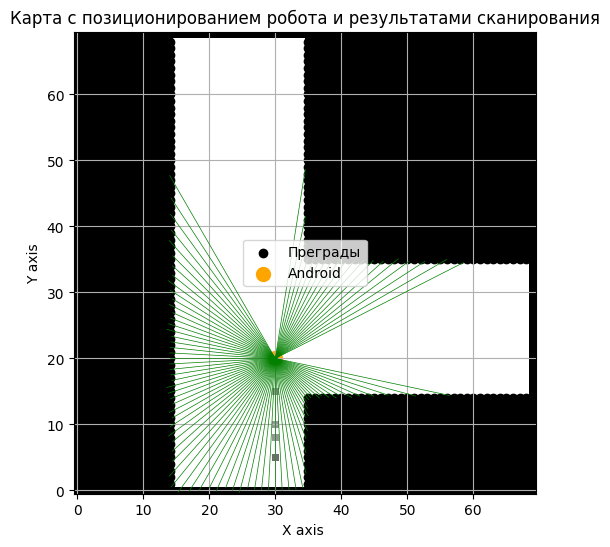

accumulated_actual_x_difference=0.0, actual_diff_y_accum=15.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-1.204333017757746, estimated_diff_y_accum=14.313521194397207, estimated_diff_theta_accum=0.10548944547042834
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=957
i=4 Grid and Map area diff: 53.07%


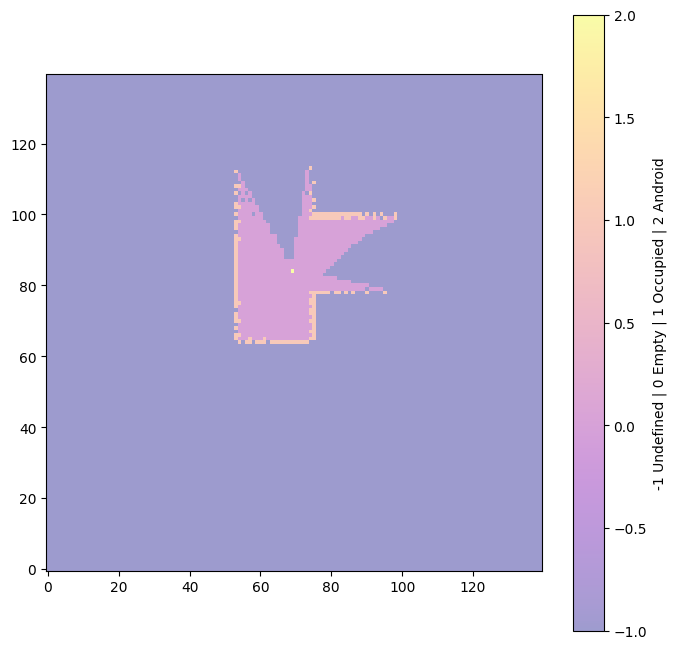

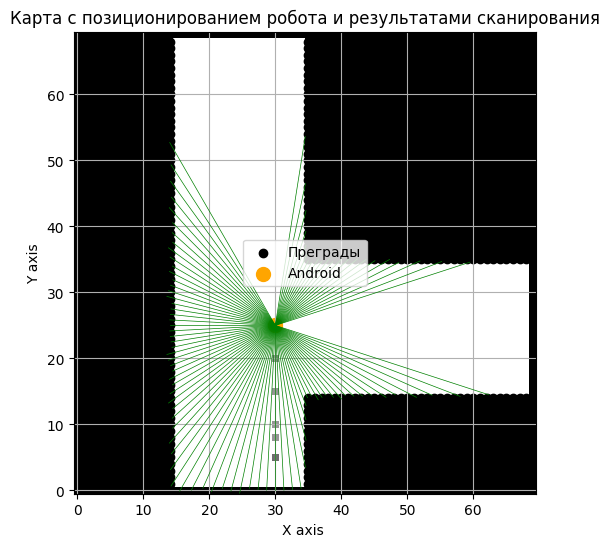

accumulated_actual_x_difference=0.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-1.6031799993196691, estimated_diff_y_accum=18.985534591021626, estimated_diff_theta_accum=0.1173216740586467
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1129
i=5 Grid and Map area diff: 44.63%


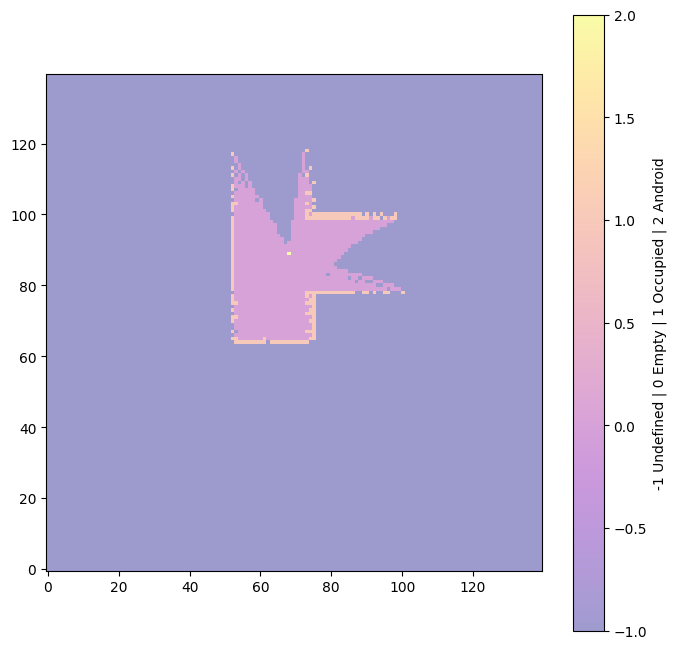

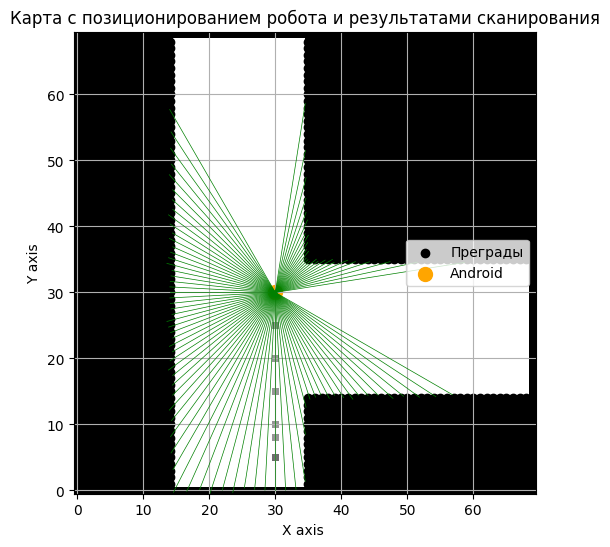

accumulated_actual_x_difference=0.0, actual_diff_y_accum=25.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-1.6430507019344192, estimated_diff_y_accum=23.640310519956984, estimated_diff_theta_accum=0.12626597578315837
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1240
i=6 Grid and Map area diff: 39.19%


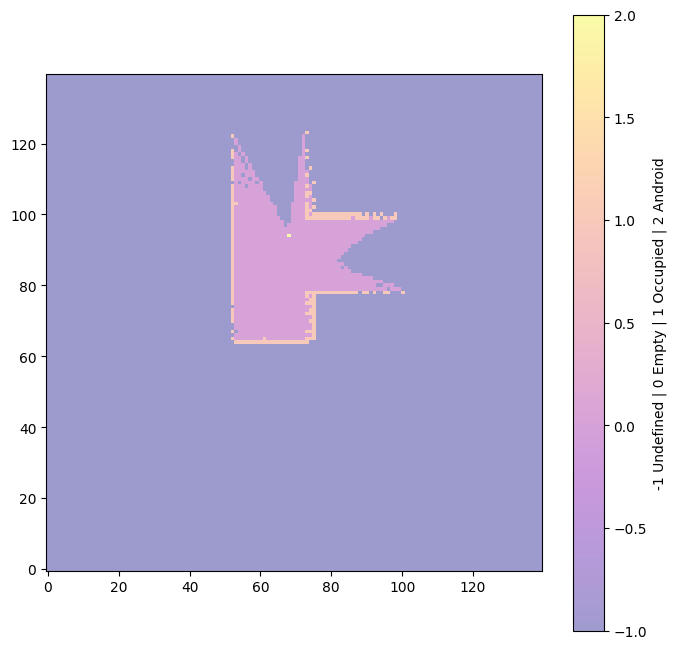

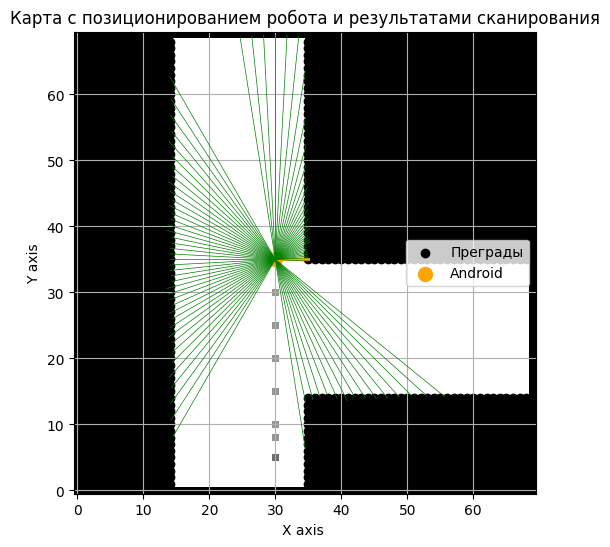

accumulated_actual_x_difference=0.0, actual_diff_y_accum=30.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-1.9615775659191739, estimated_diff_y_accum=26.372063271543965, estimated_diff_theta_accum=0.07686459630034065
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1469
i=7 Grid and Map area diff: 27.95%


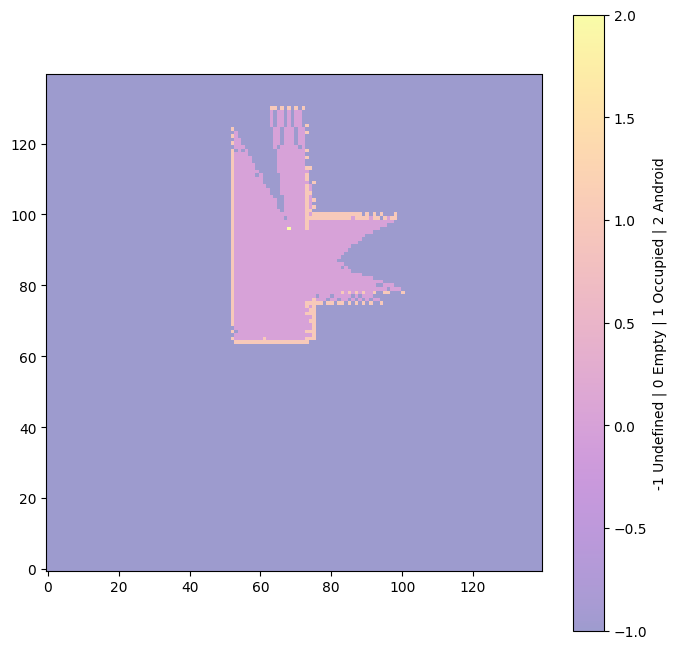

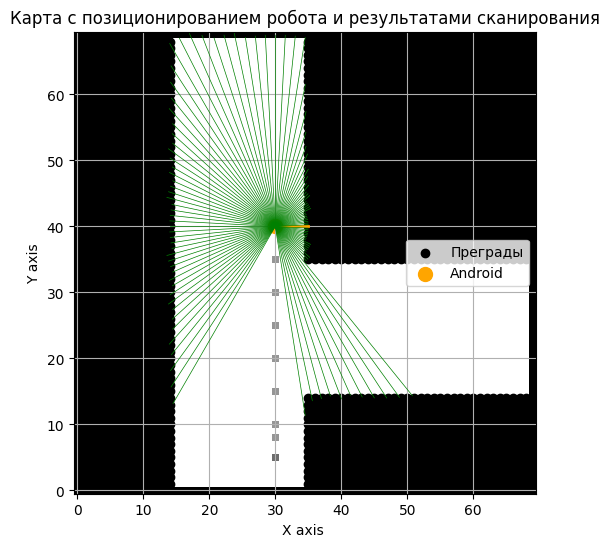

accumulated_actual_x_difference=0.0, actual_diff_y_accum=35.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-1.9223180116730418, estimated_diff_y_accum=30.660724245446715, estimated_diff_theta_accum=0.0813367359821184
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1669
i=8 Grid and Map area diff: 18.15%


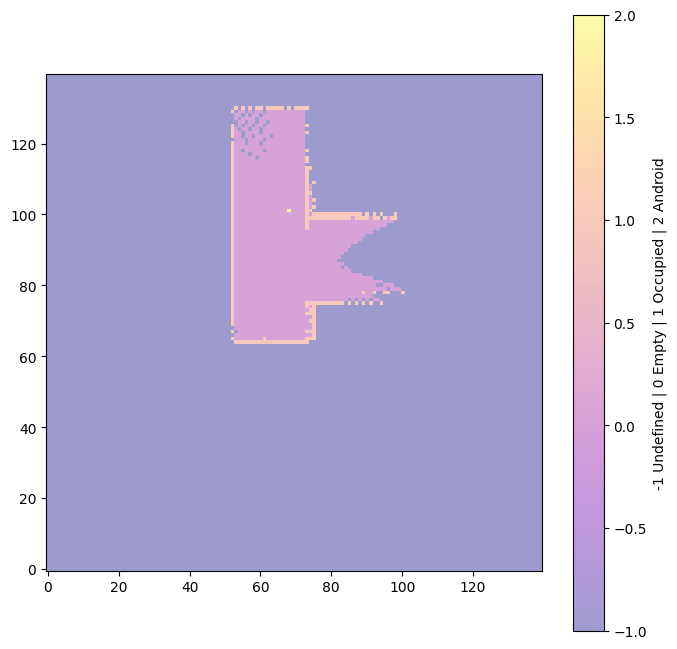

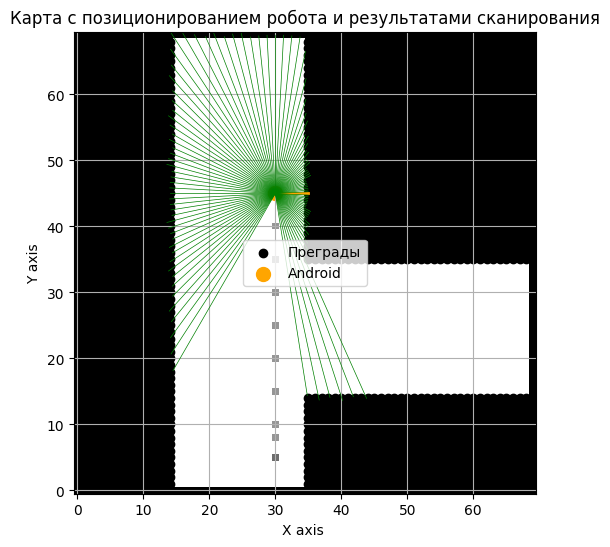

accumulated_actual_x_difference=0.0, actual_diff_y_accum=40.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-1.9310858226847558, estimated_diff_y_accum=35.72229282551495, estimated_diff_theta_accum=0.0813367359821184
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1697
i=9 Grid and Map area diff: 16.77%


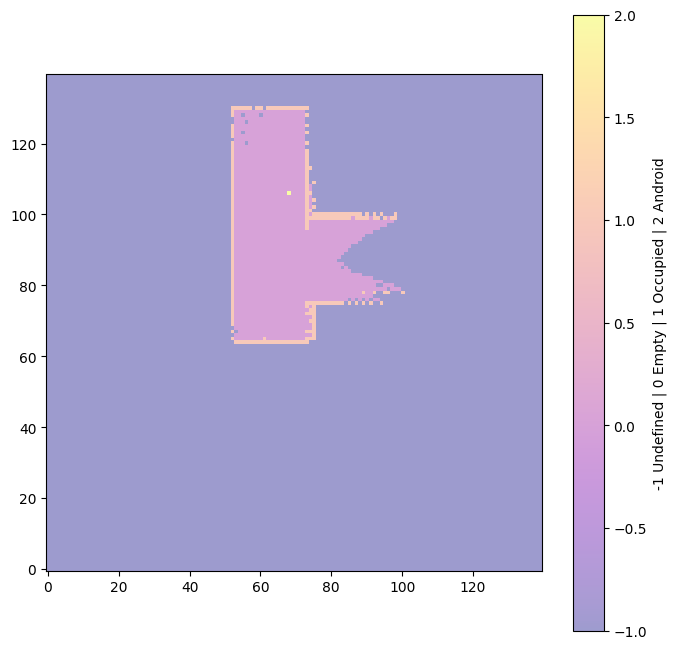

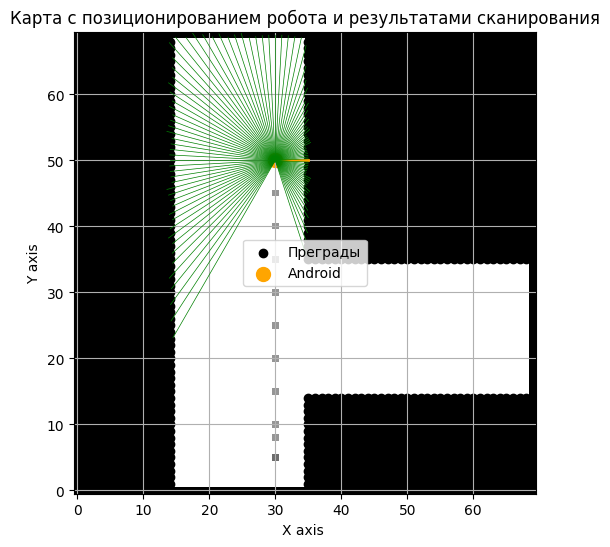

accumulated_actual_x_difference=0.0, actual_diff_y_accum=45.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-1.9453165490348812, estimated_diff_y_accum=41.2233704666501, estimated_diff_theta_accum=0.08580887566389614
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1701
i=10 Grid and Map area diff: 16.58%


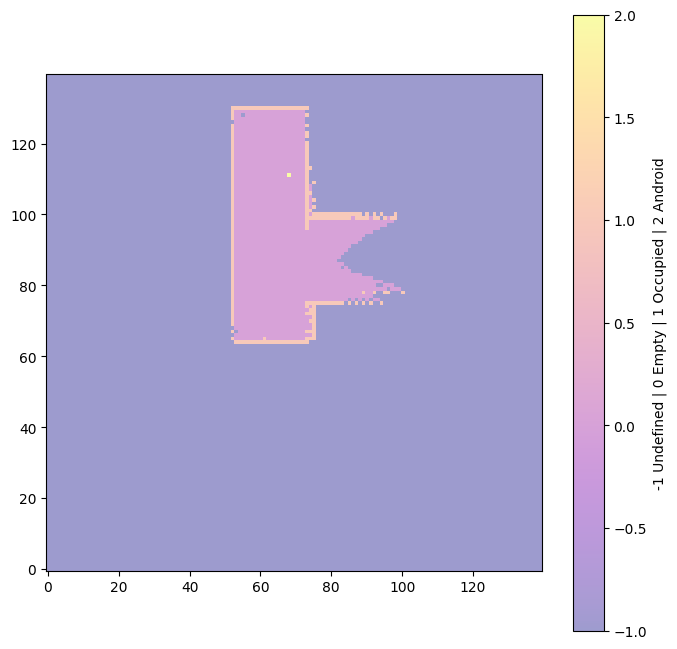

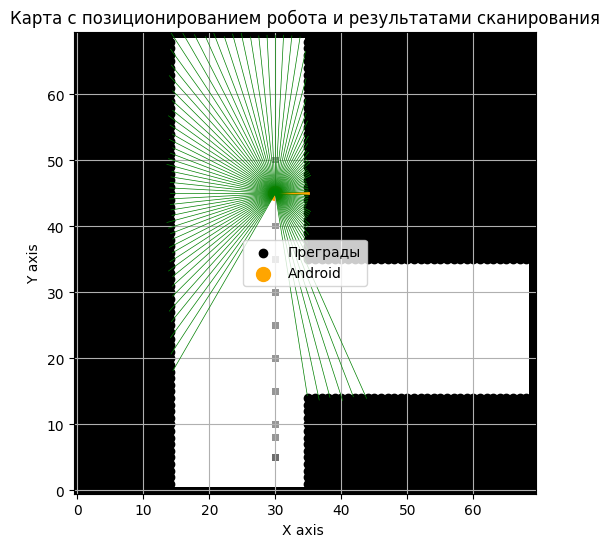

accumulated_actual_x_difference=0.0, actual_diff_y_accum=40.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-2.965641742338271, estimated_diff_y_accum=40.156566221220295, estimated_diff_theta_accum=-0.334114946431038
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1780
i=11 Grid and Map area diff: 12.70%


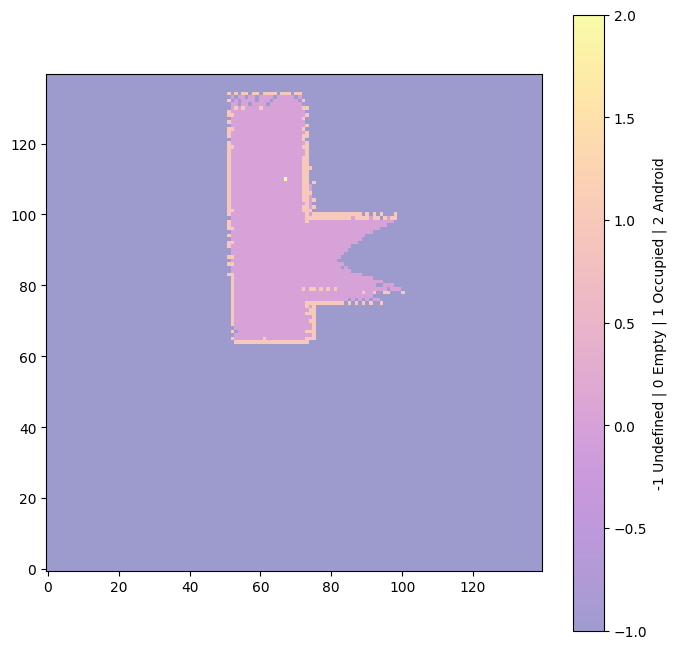

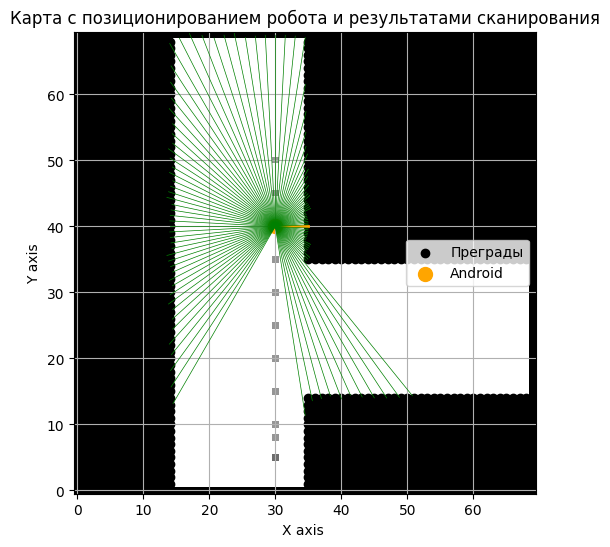

accumulated_actual_x_difference=0.0, actual_diff_y_accum=35.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-3.0548669065914686, estimated_diff_y_accum=35.75890434203349, estimated_diff_theta_accum=-0.37461462769344833
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1801
i=12 Grid and Map area diff: 11.67%


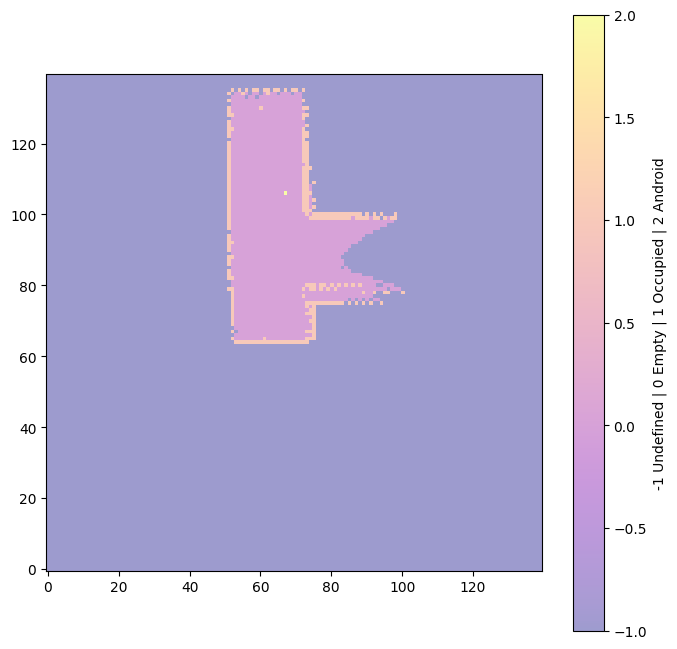

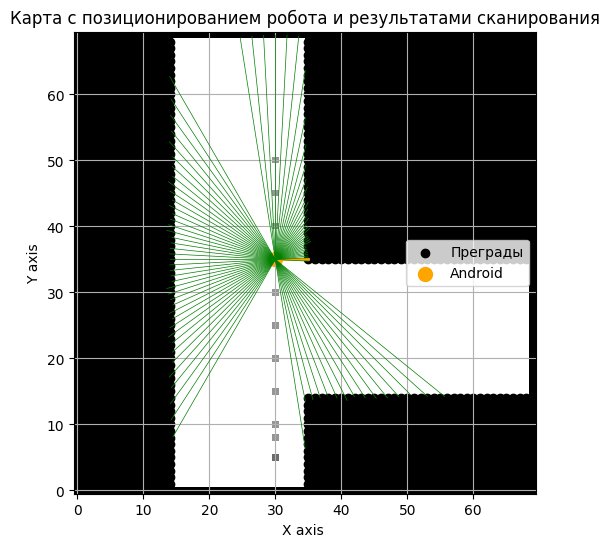

accumulated_actual_x_difference=0.0, actual_diff_y_accum=30.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-3.1315261338989644, estimated_diff_y_accum=31.238487893400833, estimated_diff_theta_accum=-0.3991101375350533
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1821
i=13 Grid and Map area diff: 10.69%


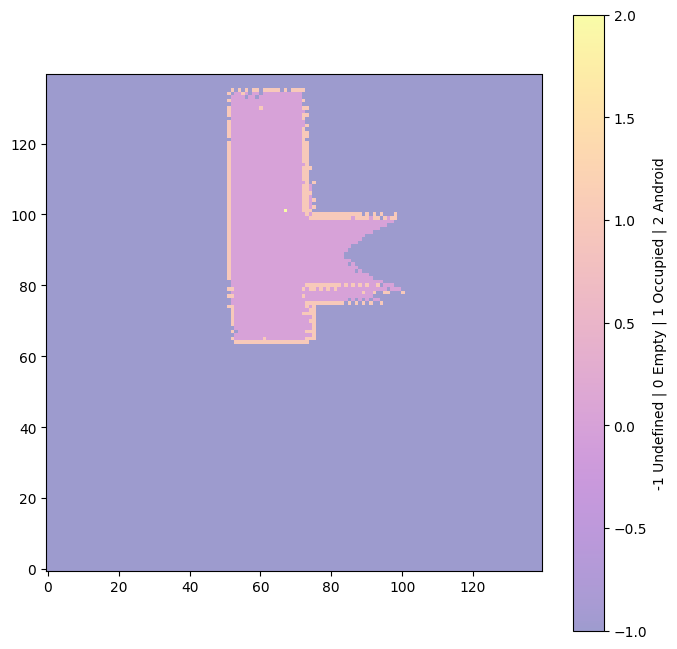

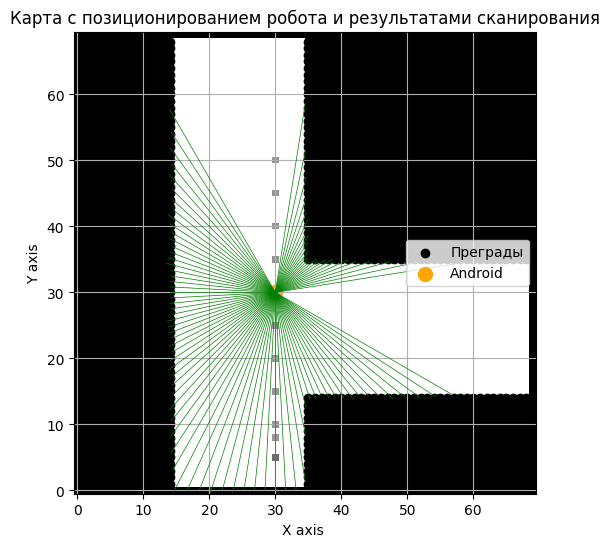

accumulated_actual_x_difference=0.0, actual_diff_y_accum=25.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-4.424680291128157, estimated_diff_y_accum=29.343966995559263, estimated_diff_theta_accum=-0.4735585057123054
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=1894
i=14 Grid and Map area diff: 7.11%


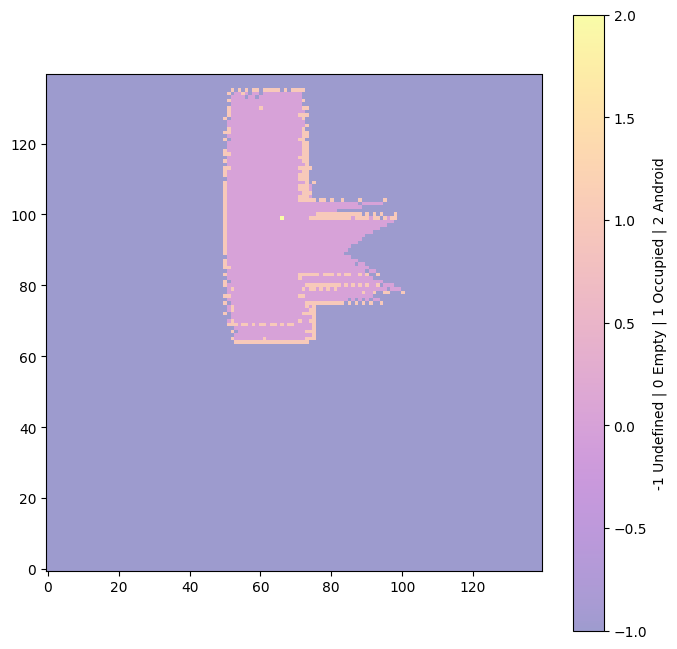

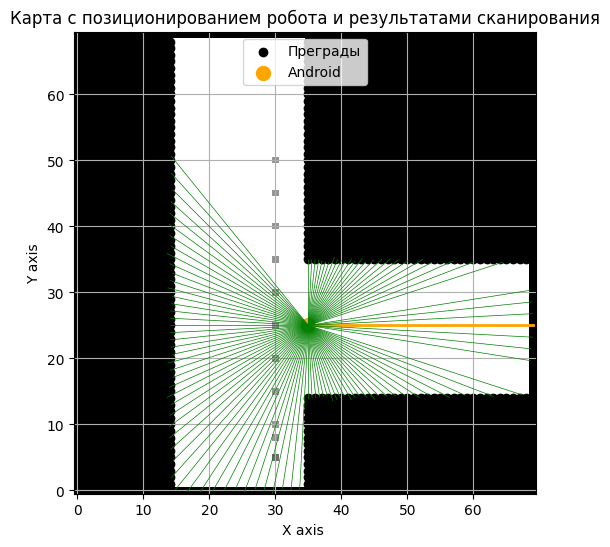

accumulated_actual_x_difference=5.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=-2.2117653274490623, estimated_diff_y_accum=23.27083275081859, estimated_diff_theta_accum=-0.4069128473898601
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=2134
i=15 Grid and Map area diff: 4.66%


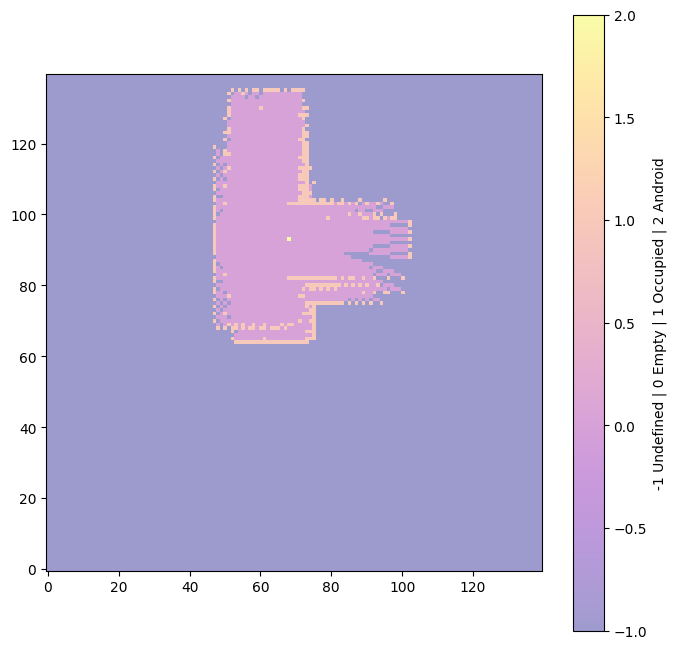

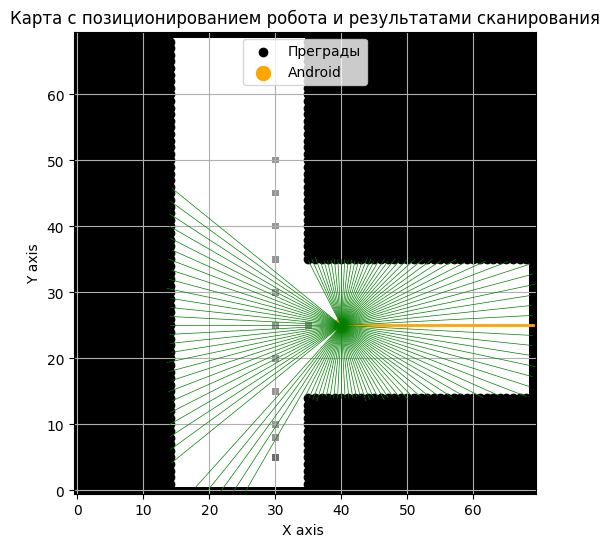

accumulated_actual_x_difference=10.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=2.5254761054242207, estimated_diff_y_accum=23.19865937173213, estimated_diff_theta_accum=-0.4005882815285472
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=2258
i=16 Grid and Map area diff: 10.74%


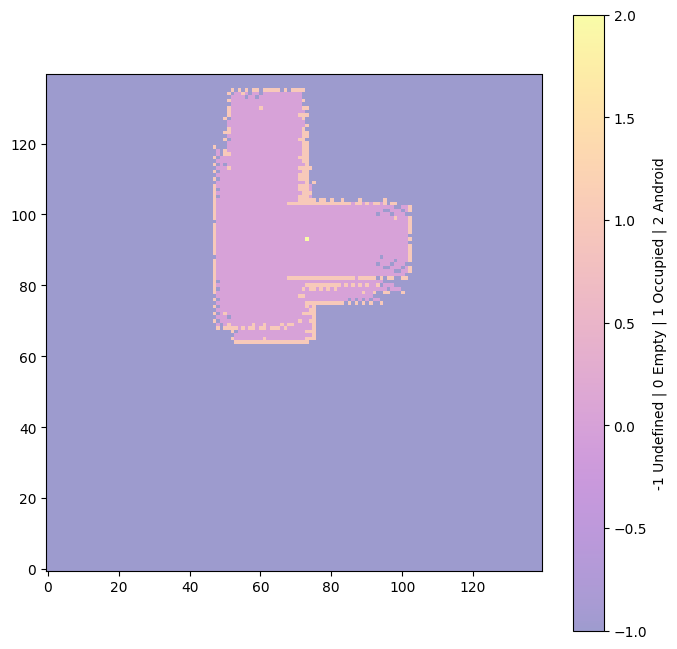

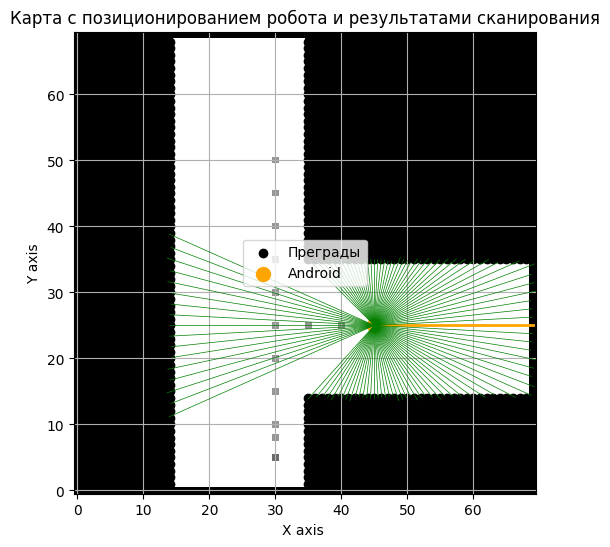

accumulated_actual_x_difference=15.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=7.387576371717855, estimated_diff_y_accum=23.1989950199336, estimated_diff_theta_accum=-0.39611614184676947
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=2264
i=17 Grid and Map area diff: 11.03%


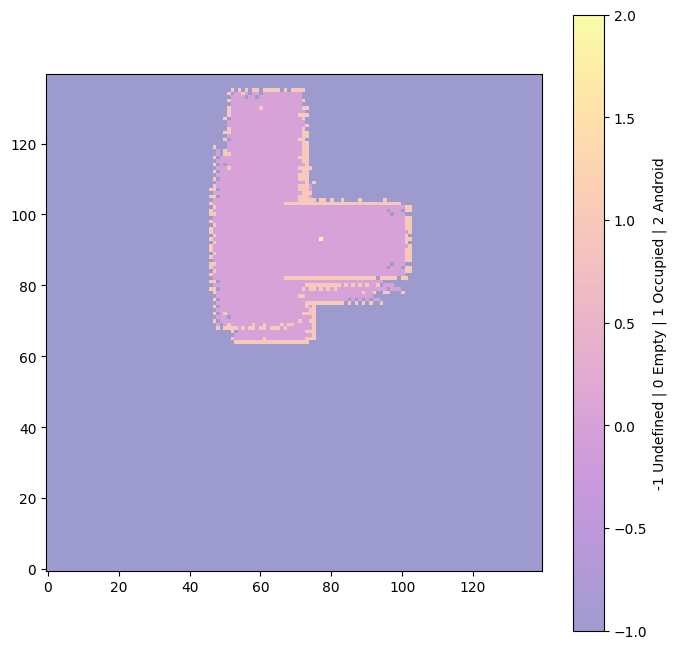

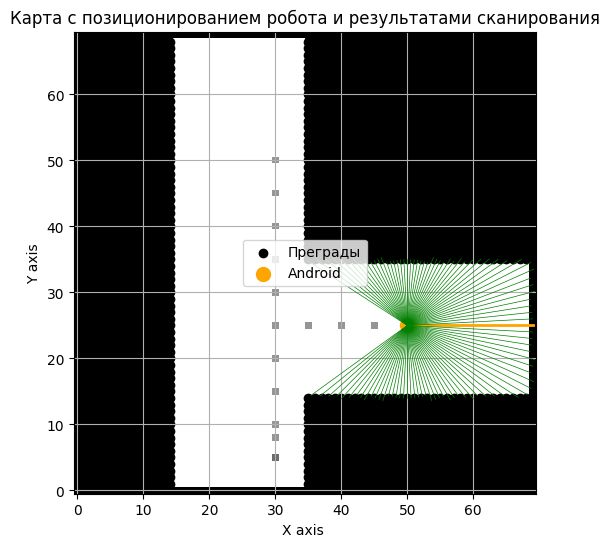

accumulated_actual_x_difference=20.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=3.5847237510539895, estimated_diff_y_accum=23.292636247850098, estimated_diff_theta_accum=-0.17325920839471975
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=2232
i=18 Grid and Map area diff: 9.47%


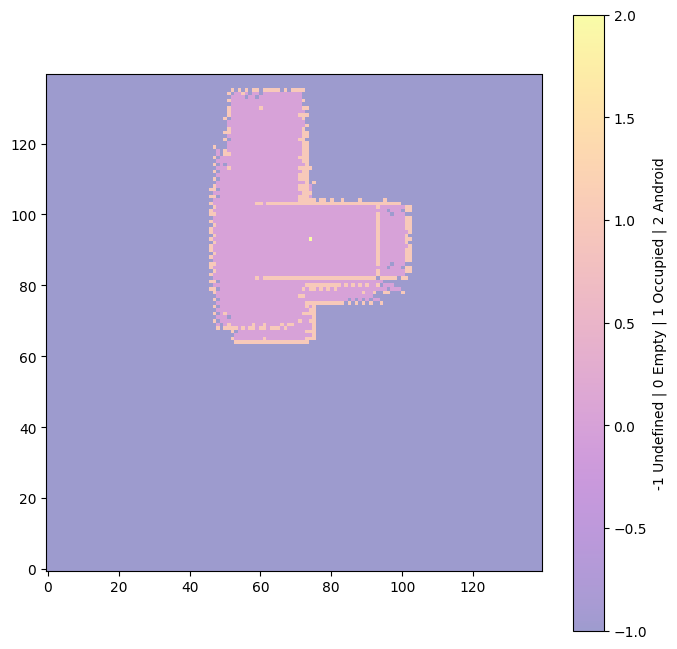

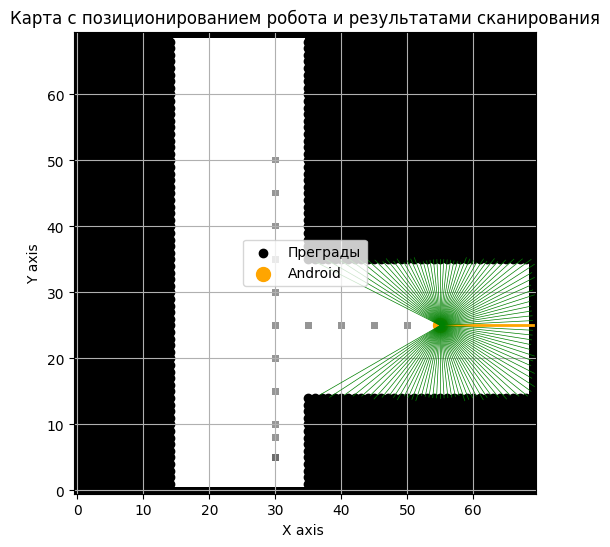

accumulated_actual_x_difference=25.0, actual_diff_y_accum=20.0, actual_diff_theta_accum=0.0
accumulated_predicted_x_difference=8.447720216761123, estimated_diff_y_accum=23.314038686088487, estimated_diff_theta_accum=-0.17325920839471975
Фактическая площадь помещения: totalBlocks=4900 openBlocks=2039
Область карты занятости:     open_blocks=2210
i=19 Grid and Map area diff: 8.39%


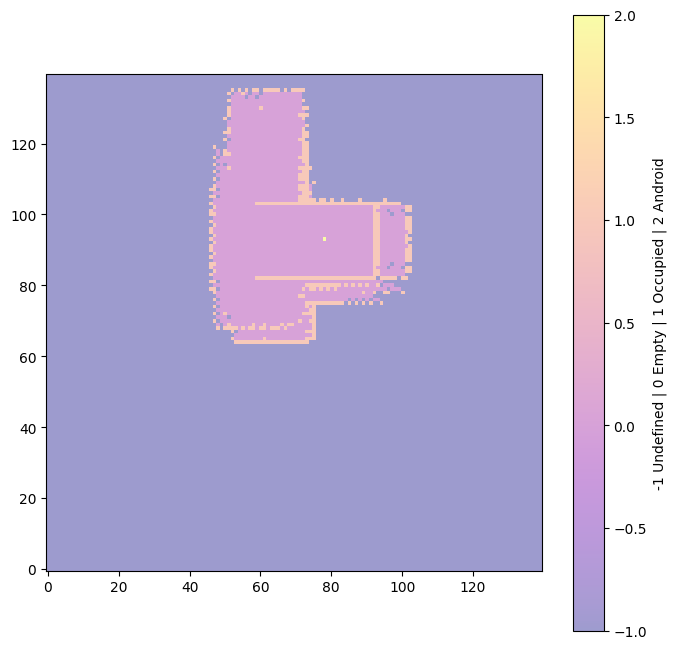

In [4]:
def transformPointCloudpycpd(dataCloud1, dataCloud2) -> [np.array, Transformation]:
    reg = RigidRegistration(X=dataCloud2, Y=dataCloud1)  # (X=target, Y=source)
    TY, (s_reg, R_reg, t_reg) = reg.register()  # returns s - scale, R - rotation matrix, t - translation vector
    return reg.transform_point_cloud(Y=dataCloud1), Transformation(s=s_reg, R=R_reg, t=t_reg)


def calculatePoseDifferenceTransformation(transformation: Transformation) -> Tuple[float, float, float]:
    global predicted_theta_sign
    cos_theta = np.round(transformation.R[0, 0], 5)

    if transformation.R[0, 1] < 0:
        predicted_theta_sign = 1
    elif transformation.R[1, 0] <= 0:
        predicted_theta_sign = -1
    ''' Предсказанная по наложению сканов трансформация'''

    cpd_predicted_theta = math.acos(cos_theta)
    cpd_predicted_theta *= predicted_theta_sign
    cpd_predicted_x = -transformation.t[0]
    cpd_predicted_y = -transformation.t[1]

    return cpd_predicted_x, cpd_predicted_y, cpd_predicted_theta


'''Выполнили сканирование (предполагаем, что позиция - 0,0).
Отразили его на карте (относительно "0,0").
1. Переместились на (x, y).
2. Произвели новое сканирование.
3. Рассчитали изменение положения (scan[-2], scan[-1]).
4. Отразили на карте, начиная с точки (old_x + estimated_x, old_y + estimated_y, old_angle + estimated_angle).
Повторяем шаг 3, пока есть место для продолжения.'''


def displayScanMatchingSumm(pose1: Robot_Position, pose2: Robot_Position, transformation: Transformation) -> None:
    global estimated_theta_sign
    DECIMALS_TO_ROUND = 3

    cosineTheta = np.round(transformation.R[0, 0], 5)  # чтобы 1.0000000007 не ломала math.acos
    if transformation.R[0, 1] < 0:
        estimated_theta_sign = 1
    elif transformation.R[1, 0] <= 0:
        estimated_theta_sign = -1

    ''' Предсказанная по наложению сканов трансформация'''
    cpdPredictedTheta = math.acos(cosineTheta)
    cpdPredictedTheta *= estimated_theta_sign
    cpdPredictedX = -transformation.t[0]  # почему "-" ??? :)
    cpdPredictedY = -transformation.t[1]

    ''' Истиная трансформация'''
    realXtranslation = pose2.x - pose1.x
    realYtranslation = pose2.y - pose1.y
    actualThetaTranslation = pose2.theta - pose1.theta

    '''  Разница трансформаций'''
    deltaX = realXtranslation - cpdPredictedX
    deltaY = realYtranslation - cpdPredictedY
    deltaTheta = actualThetaTranslation - cpdPredictedTheta

    '''  Округление'''
    cpdPredictedTheta = np.round(cpdPredictedTheta, DECIMALS_TO_ROUND)
    cpdPredictedX = np.round(cpdPredictedX, DECIMALS_TO_ROUND)
    cpdPredictedY = np.round(cpdPredictedY, DECIMALS_TO_ROUND)
    realXtranslation = np.round(realXtranslation, DECIMALS_TO_ROUND)
    realYtranslation = np.round(realYtranslation, DECIMALS_TO_ROUND)
    actualThetaTranslation = np.round(actualThetaTranslation, DECIMALS_TO_ROUND)
    deltaX = np.round(abs(deltaX), DECIMALS_TO_ROUND)
    deltaY = np.round(abs(deltaY), DECIMALS_TO_ROUND)
    deltaTheta = np.round(abs(deltaTheta), DECIMALS_TO_ROUND)

    diff_x_from_room = np.round(deltaX / GRID_SIZE * 100, DECIMALS_TO_ROUND)
    diff_y_from_room = np.round(deltaY / GRID_SIZE * 100, DECIMALS_TO_ROUND)
    diff_theta_from_2pi = np.round(deltaTheta / math.radians(360) * 100, DECIMALS_TO_ROUND)

    translation_vector_length = round(
        math.sqrt((deltaX) ** 2 + (deltaY) ** 2)
        , 3
    )
    room_diagonal_length = GRID_SIZE * math.sqrt(2)
    translation_vector_accuracy = round(translation_vector_length / room_diagonal_length * 100, 3)

    print(f"{GRID_SIZE=} {angleIncrementLidar=} {pose1=} {pose2=}")
    print(f"Точность преобразования вектора X/Y - {translation_vector_accuracy}%")

    print("Фактическое преобразвание")
    print(f"\tX\t{realXtranslation}")
    print(f"\tY\t{realYtranslation}")
    print(f"\tθ(rad)\t{actualThetaTranslation}")

    print(" Расчитанное преобразование ")
    print(f"\tX\t{cpdPredictedX}")
    print(f"\tY\t{cpdPredictedY}")
    print(f"\tθ(rad)\t{cpdPredictedTheta}")

    print(" Отличие в преобразованиях (% от общей площади комнаты) ")
    print(f"\tX\t{deltaX} ({diff_x_from_room}%)")
    print(f"\tY\t{deltaY} ({diff_y_from_room}%)")
    print(f"\tθ(rad)\t{deltaTheta} ({diff_theta_from_2pi}%) (% от 2*Pi)")


OCCUPANCY_GRID_SHIFT_X = GRID_SIZE
OCCUPANCY_GRID_SHIFT_Y = GRID_SIZE


def generateBresenhamLine(x0, y0, x1, y1):
    '''  Преобразуем плавающие координаты в целочисленные координаты '''
    x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))

    return points


def updateGridOccupancy(grid: np.array, robot_pos: Robot_Position, scan_distances, angles, max_distance):
    adjustedRobotPose = Robot_Position(x=robot_pos.x + OCCUPANCY_GRID_SHIFT_X,
                                       y=robot_pos.y + OCCUPANCY_GRID_SHIFT_Y,
                                       theta=robot_pos.theta)
    adjustedRobotPose.x = round(adjustedRobotPose.x)
    adjustedRobotPose.y = round(adjustedRobotPose.y)

    grid[adjustedRobotPose.y, adjustedRobotPose.x] = 2
    for angle, distance in zip(angles, scan_distances):
        rad = np.radians(angle)
        for r in range(1, max_distance):
            x = round(adjustedRobotPose.x + r * np.cos(rad))
            y = round(adjustedRobotPose.y + r * np.sin(rad))
            if r < distance:
                grid[y, x] = 0  # Mark as free
            elif r == distance and distance != -1:
                grid[y, x] = 1
                break


def updateGridFromNewScanning(grid, previousRobotPosition, newRobotPosition, updatedScanDistances, updatedAngles,
                              maximumDistance):
    '''  Пометить старую позицию робота как свободную '''

    previousRobotposX = round(previousRobotPosition.x)
    previousRobotposY = round(previousRobotPosition.y)
    grid[(previousRobotposX + OCCUPANCY_GRID_SHIFT_X, previousRobotposY + OCCUPANCY_GRID_SHIFT_X)[::-1]] = 0
    updateGridOccupancy(grid, newRobotPosition, updatedScanDistances, updatedAngles, maximumDistance)


def initializeOccupancyGridMap() -> np.array:
    return np.full((GRID_SIZE * 2, GRID_SIZE * 2), -1)


def displayOccupancyGridMap(occupancy_grid_map: np.array) -> None:
    plt.figure(figsize=(8, 8))
    plt.imshow(occupancy_grid_map, cmap='plasma', origin='lower', alpha=0.4)
    plt.colorbar(label='-1 Undefined | 0 Empty | 1 Occupied | 2 Android')


def calculateMapArea(map_: np.array) -> float:
    totalBlocks = map_.size
    openBlocks = np.count_nonzero(map_ == 0) + np.count_nonzero(map_ == 0.5)

    print(f"Фактическая площадь помещения: {totalBlocks=} {openBlocks=}")
    return openBlocks


def calculateOccupancyGridMapArea(map_: np.array) -> float:
    open_blocks = np.count_nonzero(map_ == 0) + np.count_nonzero(map_ == 2)
    print(f"Область карты занятости: {    open_blocks=}")
    return open_blocks


def performTestExperiment(experimentEnvironment: RoomTestSetup):
    currentActualRobotPosition = experimentEnvironment.androidpositions[0]
    room = createRoom(GRID_SIZE, experimentEnvironment.blockpositions, experimentEnvironment.androidpositions[0])

    gridMapWithOccupancy = initializeOccupancyGridMap()
    distanceMeasurementsScan, angles = laserDistancesScan(currentActualRobotPosition, room.map_as_2d_array)
    displayScanResults(currentActualRobotPosition, distanceMeasurementsScan, angles, room.map_as_2d_array,
                       room.obstacle_positions)

    predictedRobotPos1 = Robot_Position(x=0, y=0, theta=0)
    updateGridOccupancy(gridMapWithOccupancy, predictedRobotPos1, distanceMeasurementsScan, angles,
                        maximumDistanceLidar)

    displayOccupancyGridMap(gridMapWithOccupancy)

    accumulated_actual_x_difference, actual_diff_y_accum, actual_diff_theta_accum = 0.0, 0.0, 0.0
    accumulated_predicted_x_difference, estimated_diff_y_accum, estimated_diff_theta_accum = 0.0, 0.0, 0.0

    for i, pose in enumerate(experimentEnvironment.androidpositions[1:], start=1):
        previous_actual_robot_pose: Robot_Position = experimentEnvironment.androidpositions[i - 1]
        currentActualRobotPosition: Robot_Position = pose
        scan_distances2, angles2 = laserDistancesScan(currentActualRobotPosition, room.map_as_2d_array)
        room.map_as_2d_array[(currentActualRobotPosition.x, currentActualRobotPosition.y)[::-1]] = 0.5
        displayScanResults(currentActualRobotPosition, scan_distances2, angles2, room.map_as_2d_array,
                           room.obstacle_positions)

        # оцениваем трансформацию
        dataCloud1 = generatePointCloudFromScan(distanceMeasurementsScan, angles)
        dataCloud2 = generatePointCloudFromScan(scan_distances2, angles2)
        transformedDataCloud1, transformation = transformPointCloudpycpd(dataCloud1, dataCloud2)
        estimated_diff_x, estimated_diff_y, estimated_diff_theta = calculatePoseDifferenceTransformation(transformation)
        acutal_diff_x, acutal_diff_y, actual_diff_theta = currentActualRobotPosition.x - previous_actual_robot_pose.x, currentActualRobotPosition.y - previous_actual_robot_pose.y, currentActualRobotPosition.theta - previous_actual_robot_pose.theta,
        accumulated_actual_x_difference += acutal_diff_x
        actual_diff_y_accum += acutal_diff_y
        actual_diff_theta_accum += actual_diff_theta
        accumulated_predicted_x_difference += estimated_diff_x
        estimated_diff_y_accum += estimated_diff_y
        estimated_diff_theta_accum += estimated_diff_theta

        estimated_robot_pos2 = Robot_Position(
            x=predictedRobotPos1.x + estimated_diff_x,
            y=predictedRobotPos1.y + estimated_diff_y,
            theta=predictedRobotPos1.theta + estimated_diff_theta
        )

        print(f"{accumulated_actual_x_difference=}, {actual_diff_y_accum=}, {actual_diff_theta_accum=}")
        print(f"{accumulated_predicted_x_difference=}, {estimated_diff_y_accum=}, {estimated_diff_theta_accum=}")

        updateGridFromNewScanning(gridMapWithOccupancy, predictedRobotPos1, estimated_robot_pos2, scan_distances2,
                                  angles2, maximumDistanceLidar)
        displayOccupancyGridMap(gridMapWithOccupancy)

        distanceMeasurementsScan, angles = scan_distances2, angles2
        predictedRobotPos1 = estimated_robot_pos2

        actual_room_area = calculateMapArea(room.map_as_2d_array)
        occupancy_grid_map_area = calculateOccupancyGridMapArea(gridMapWithOccupancy)

        area_diff_percent = abs((actual_room_area - occupancy_grid_map_area) / actual_room_area * 100)

        print(f"{i=} Grid and Map area diff: {area_diff_percent:.2f}%")


performTestExperiment(test_configuration1)
